# Applied Programming Coding Challenge #1

![title](../img/photo-1533788179956-82e8a027c962.jpg)

# General Information

## Data Set and Features

The project [Bike Sharing Dataset](https://www.kaggle.com/lakshmi25npathi/bike-sharing-dataset) contains two data sets
* day.csv
* hour.csv

Both shall be used to predict demand of bikes using regression.
  
There are 16 (17 respectively) features in each of the two data sets
* ```instant``` Unique ID of a record
* Features describing time
  * ```dteday``` Date, e.g. 01.01.2011
  * ```season``` Numerically encoded season, e.g. 1 (=spring)
  * ```yr``` Year after start (Jan 1 2011), e.g. 0
  * ```mnth``` Month of the year, e.g. 1 (=January)
  * ```hour``` Hour of the day
  * ```holiday``` Indicator whether the day is a public holiday, e.g. 0 (=no)
  * ```weekday``` Numerically encoded weekday of the date, e.g. 0 (=Sunday)
  * ```workingday```  Indicator whether the day is a working day, e.g. 0 (=no)
* Features describing weather
  * ```weathersit``` Numerically encoded weather situation, e.g.
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
  * ```temp``` Normalized temperature in Celsius
  * ```atemp``` Normalized _feeling_ temperature in Celsius
  * ```hum``` Normalized humidity
  * ```windspeed``` Normalized wind speed
* Features describing rented bikes
  * ```casual``` Number of casual users
  * ```registered``` Number of registered users
  * ```cnt``` Combined number of casual and registered users

Some features are already normalized
* ```temp```
* ```atemp```
* ```hum```
* ```windspeed```

## Overall structure and Python classes being used

In the course of this notebook different setups will be trained, evaluated and compared with each other

* 2 **data sets** (```day``` and ```hour```)
  * 4 **variants** (```original```, ```market```, ```history```, ```reduced```)
    * 10 **folds**
    * 7 **models** (```Linear Regression```, ```Decision Tree Regressor```, ```Random Forest Regressor```, 
    ```Gradient Boosting Regressor```, ```Lasso```, ```Elastic Net```, ```Ridge```)
      * 1 **metric** (```R² score```)

In order to handle the different setups effectively therefore the following classes will be used

* ```DataSet``` representing the two data sets _day_ and _hour_
* ```Variant``` representing different variants two be compared (see chapter _Hypotheses_)
* ```DataSplit``` storing x_train, x_test, y_train, y_test of a train/test data split

In [1]:
%matplotlib inline

In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# 1 Load data

```TIP FOR DEVS``` Put column names into variables in order to benefit from code completion

In [4]:
# Original columns
col_instant = 'instant'
col_datetime = 'datetime'
col_season = 'season'
col_year = 'year'
col_month = 'month'
col_hour = 'hour'
col_holiday = 'holiday'
col_weekday = 'weekday'
col_workingday = 'workingday'
col_weather_situation = 'weather_situation'
col_temperature = 'temperature'
col_apparent_temperature = 'apparent_temperature'
col_humidity = 'humidity'
col_windspeed = 'windspeed'

# Historic columns
col_weather_situation_hist = 'weather_situation_hist'
col_temperature_hist = 'temperature_hist'
col_apparent_temperature_hist = 'apparent_temperature_hist'
col_humidity_hist = 'humidity_hist'
col_windspeed_hist = 'windspeed_hist'

# Target columns
col_casual = 'casual'
col_registered = 'registered'
col_count = 'count'

# Calculated columns
col_days_since_start = 'days_since_start'

# Raw column
col_temperature_raw = 'temperature_raw'
col_apparent_temperature_raw = 'apparent_temperature_raw'
col_humidity_raw = 'humidity_raw'
col_windspeed_raw = 'windspeed_raw'
col_temperature_raw_rounded = 'temperature_raw_rounded'
col_days_since_start_raw = 'days_since_start_raw'

```TIP FOR DEVS``` Use random_state in order to ensure reproducible results

In [5]:
# Random state to generate reproducible results 
random_state = 0

In [6]:
# Data sets
data_set_day = "day"
data_set_hour = "hour"

class DataSet:
    """Contains data, model and predictions of a data set"""
    file_name = ""
    attribute_names = []
    columns_categorical = []
    data_frame = {}
    variants = {}
    
    def __init__(self, file_name):
        self.file_name = file_name

# Define data sets
data_sets = {
    data_set_day: DataSet("../data/bike-sharing-dataset/day.csv"),
    data_set_hour: DataSet("../data/bike-sharing-dataset/hour.csv")
    # data_set_day: DataSet("https://raw.githubusercontent.com/florianschwanz/fom-applied-programming-challenge/master/data/bike-sharing-dataset/day.csv"),
    # data_set_hour: DataSet("https://raw.githubusercontent.com/florianschwanz/fom-applied-programming-challenge/master/data/bike-sharing-dataset/hour.csv")
}

In [7]:
# Define attribute names
data_sets[data_set_day].attribute_names = [col_instant, col_datetime, col_season, col_year, col_month, col_holiday, 
                                           col_weekday, col_workingday, col_weather_situation, col_temperature, 
                                           col_apparent_temperature, col_humidity, col_windspeed, col_casual, 
                                           col_registered, col_count]
data_sets[data_set_hour].attribute_names = [col_instant, col_datetime, col_season, col_year, col_month, col_hour, 
                                            col_holiday, col_weekday, col_workingday, col_weather_situation, 
                                            col_temperature, col_apparent_temperature, col_humidity, col_windspeed, 
                                            col_casual, col_registered, col_count]

In [8]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Read csv file
    data_set.data_frame = pd.read_csv(data_set.file_name, skiprows=1, names=data_set.attribute_names)

## 2 Understand data

* Make sure data is plausible

### 2.1 Show basic facts

* Show data types of features
* Make sure there are no null values

In [9]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    data_set.data_frame.info()
    data_set.data_frame.isnull().sum()
    print("")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant                 731 non-null int64
datetime                731 non-null object
season                  731 non-null int64
year                    731 non-null int64
month                   731 non-null int64
holiday                 731 non-null int64
weekday                 731 non-null int64
workingday              731 non-null int64
weather_situation       731 non-null int64
temperature             731 non-null float64
apparent_temperature    731 non-null float64
humidity                731 non-null float64
windspeed               731 non-null float64
casual                  731 non-null int64
registered              731 non-null int64
count                   731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant                 

## 2.2 Set data types

Data types are assigned to features in order to make it easier to use them e.g. for calculations in further steps.
This includes
* date time data
* categorical data

In [10]:
# Define categorical attributes
data_sets[data_set_day].columns_categorical = [col_season, col_year, col_month, col_holiday, col_weekday,
                                               col_workingday, col_weather_situation]
data_sets[data_set_hour].columns_categorical = [col_season, col_year, col_month, col_hour, col_holiday, col_weekday,
                                                col_workingday, col_weather_situation]

In [11]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Convert columns to date time
    data_set.data_frame[col_datetime] = pd.to_datetime(data_set.data_frame[col_datetime])

    # Convert columns to category
    for column in data_set.columns_categorical:
        data_set.data_frame[column]=data_set.data_frame[column].astype('category')

## 2.3 Restore raw data

* Some features in the data sets are already normalized
* For better visualization they need to be de-normalized first (using extreme values from data set's readme file)

In [12]:
# Extreme temperature values
temperature_min=-8
temperature_max=39
# Extreme apparent temperature values
apparent_temperature_min=-16
apparent_temperature_max=50
# Extreme humidity value
humidity_max=100
# Extreme wind speed value
windspeed_max=67

In [13]:
# Define columns containing raw-values
columns_raw_values = [col_temperature_raw, col_apparent_temperature_raw, col_humidity_raw, col_windspeed_raw,
                      col_temperature_raw_rounded]

In [14]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Restore raw values for day data frame
    data_set.data_frame = data_set.data_frame.assign(temperature_raw=data_set.data_frame[col_temperature] * (temperature_max-temperature_min) + temperature_min)
    data_set.data_frame = data_set.data_frame.assign(apparent_temperature_raw=data_set.data_frame[col_apparent_temperature] * (apparent_temperature_max-apparent_temperature_min) + apparent_temperature_min)
    data_set.data_frame = data_set.data_frame.assign(humidity_raw=data_set.data_frame[col_humidity] * humidity_max)
    data_set.data_frame = data_set.data_frame.assign(windspeed_raw=data_set.data_frame[col_windspeed] * windspeed_max)

    # Round values for better visualization
    data_set.data_frame = data_set.data_frame.assign(temperature_raw_rounded=round(data_set.data_frame[col_temperature_raw]/5,0)*5)

## 2.4 Show data

```WARNING``` DataFrame.head() does not work inside loops

In [15]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Show first few lines
    data_set.data_frame.head()

In [16]:
data_sets[data_set_day].data_frame.head()

,instant,datetime,season,year,month,holiday,weekday,workingday,weather_situation,temperature,...,humidity,windspeed,casual,registered,count,temperature_raw,apparent_temperature_raw,humidity_raw,windspeed_raw,temperature_raw_rounded
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0.805833,0.160446,331,654,985,8.175849,7.999250,80.5833,10.749882,10.0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0.696087,0.248539,131,670,801,9.083466,7.346774,69.6087,16.652113,10.0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0.437273,0.248309,120,1229,1349,1.229108,-3.499270,43.7273,16.636703,0.0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0.590435,0.160296,108,1454,1562,1.400000,-1.999948,59.0435,10.739832,0.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0.436957,0.186900,82,1518,1600,2.666979,-0.868180,43.6957,12.522300,5.0


In [17]:
data_sets[data_set_hour].data_frame.head()

,instant,datetime,season,year,month,hour,holiday,weekday,workingday,weather_situation,...,humidity,windspeed,casual,registered,count,temperature_raw,apparent_temperature_raw,humidity_raw,windspeed_raw,temperature_raw_rounded
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.81,0.0,3,13,16,3.28,3.0014,81.0,0.0,5.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.80,0.0,8,32,40,2.34,1.9982,80.0,0.0,0.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.80,0.0,5,27,32,2.34,1.9982,80.0,0.0,0.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.75,0.0,3,10,13,3.28,3.0014,75.0,0.0,5.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.75,0.0,0,1,1,3.28,3.0014,75.0,0.0,5.0


## 2.5 Plot relation between month and number of rented bikes

* Expected plot contains few peaks (most popular biking months)

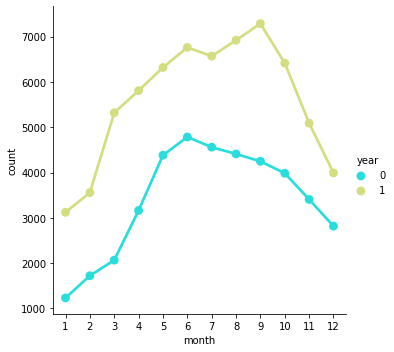

In [18]:
# Plot trend
sns.catplot(col_month,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')

## 2.6 Plot relation between temperature and number of rented bikes

* Expected plot contains one peak (optimal biking temperature)

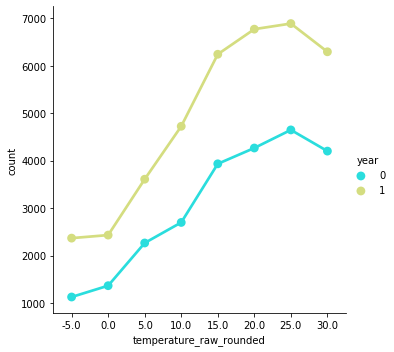

In [19]:
# Plot trend
sns.catplot(col_temperature_raw_rounded,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')

## 2.7 Plot relation between weather situation and number of rented bikes

* Expected plot indicates that there are significantly more rentals on day having good weather (clear or misty)
  * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
  * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

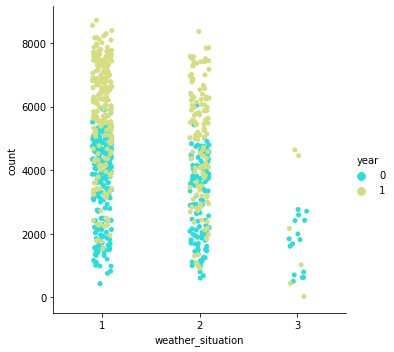

In [20]:
# Plot trend
sns.catplot(col_weather_situation,col_count,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='strip', palette='rainbow')

## 2.8 Plot relation between hour of the day and number of rented bikes

* Expected plot indicates that more bikes are rented by **casual casual** during mid day
  * Probably when tourists and people on holidays move through the city
* Expected plot indicates that more bikes are rented by **registered users** during rush hours
  * Probably there are two peeks when people go to work / go back home

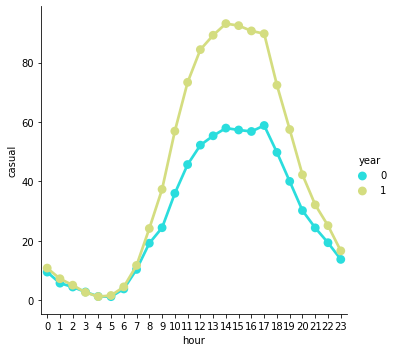

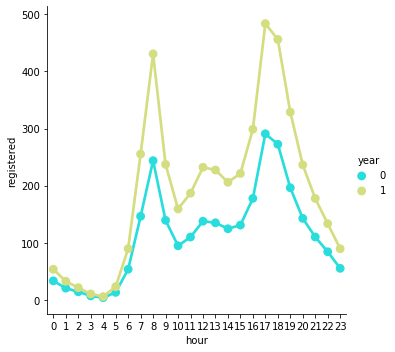

In [21]:
# Plot trend
sns.catplot(col_hour,col_casual,hue=col_year,data=data_sets[data_set_hour].data_frame, ci=None, kind='point', palette='rainbow')
sns.catplot(col_hour,col_registered,hue=col_year,data=data_sets[data_set_hour].data_frame, ci=None, kind='point', palette='rainbow')

## 2.9 Plot relation between day of the week and number of rented bikes

* Expected plot indicates that more bikes are rented by **casual users** on weekends
* Expected plot indicates that more bikes are rented by **registered users** on week days

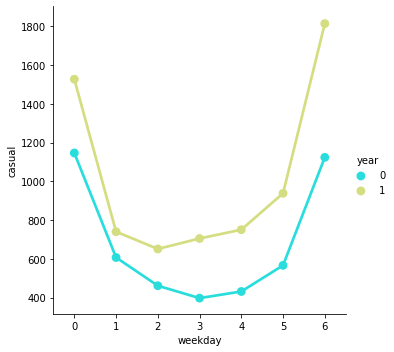

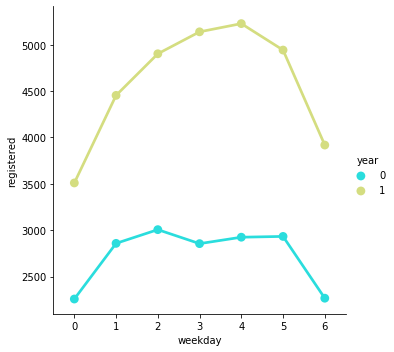

In [22]:
# Plot trend
sns.catplot(col_weekday,col_casual,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')
sns.catplot(col_weekday,col_registered,hue=col_year,data=data_sets[data_set_day].data_frame, ci=None, kind='point', palette='rainbow')

## 2.10 Plot correlation matrix of some attributes

* Expected matrix contains the following correlations
  * strong correlation between _temperature_ and _apparent temperature_

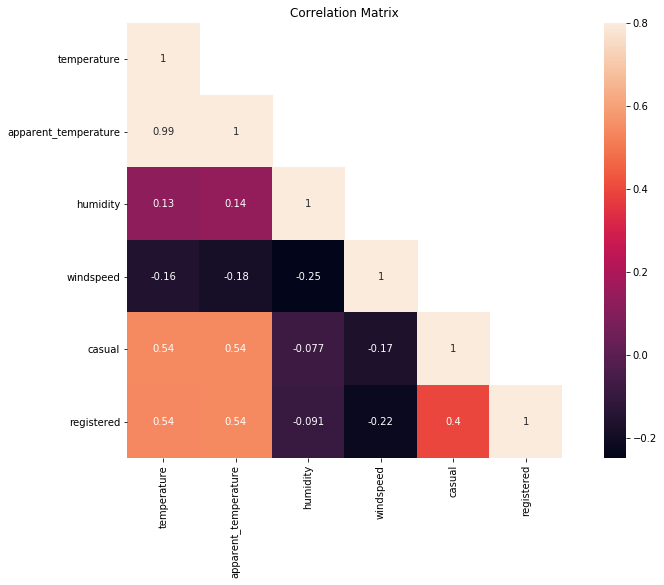

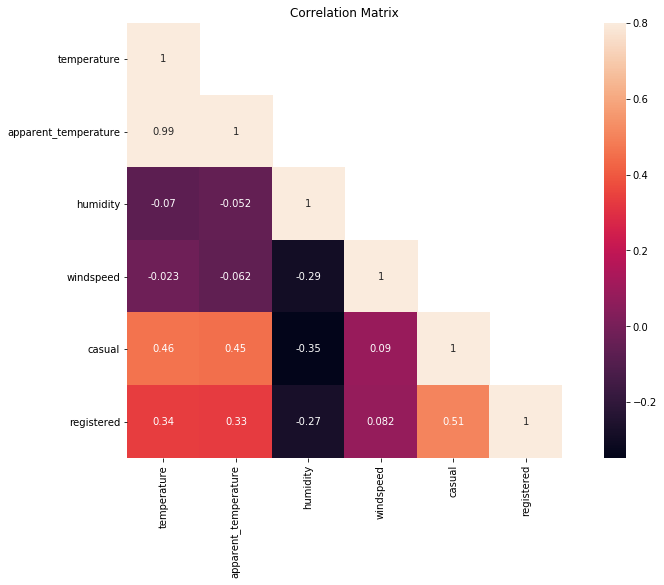

In [23]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Plot correlation matrix
    correlationMatrix=data_set.data_frame[[col_temperature, col_apparent_temperature, col_humidity,col_windspeed,
                                           col_casual, col_registered]].corr()
    mask=np.array(correlationMatrix)
    mask[np.tril_indices_from(mask)]=False

    fig,ax=plt.subplots(figsize=(15,8))
    sns.heatmap(correlationMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
    ax.set_title('Correlation Matrix')
    plt.show()

# 3 Hypotheses

Based on the basic understanding of the data sets two hypotheses shall be made

In the course of this notebook the data sets will be extended by additional information
* days since start of the bike sharing campaign
* weather conditions of previous period

## 3.1 Hypothesis A <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fe0e0;">time in the market</span>

There is a significant difference in the number of rented bikes in the two years being contained in the data set. 
Therefore it can be assumed that the raising popularity correlates with the number of rented bikes.
In order to include this assumption a synthentic feature ```days since start``` shall be used.

*Hypothesis* Taking into account the number of days since the bike sharing campaign has started will increase the 
performance of the model.

## 3.2 Hypothesis B  <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fb5e0;">historic weather data</span>

Different aspects of the weather affect how many bikes are rented. In most cases there may be time between _deciding to 
use a shared bike_ and _actually using it_. Therefore also the weather conditions of the time period 
_before_ a bike is rented may be relevant. In order to achieve this some synthetic features such as 
```weather_situation_hist```, ```temperature_hist```, ```apparent_temperature_hist```, ```humidity_hist```, 
```windspeed_hist``` shall be included which reflect the weather situation of the previous row.

*Hypothesis* Taking into account the weather conditions of the previous period will increase the 
performance of the model.

## 3.3 Hypothesis C <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #ff8080;">dimensionality reduction</span>

Features ```temperature``` and ```apparent_temperature``` strongly correlate with each other. It is to be assumed that 
dropping one of the two does not reduce model performance.

*Hypothesis* Dropping _apparent temperature_ does not decrease performance of the model.

# 4 Preprocess data

## 4.1 Initialize variants

Three variants will be trained and evaluated
* <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #e9edbf;">original</span> original data frame
* <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fe0e0;">market</span> original data frame + days since start
* <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fb5e0;">history</span> original data frame + history weather conditions
* <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #ff8080;">reduced</span> original data frame + manual dimensionality reduction

In [24]:
# Variants
variant_original = "original"
variant_market = "market"
variant_history = "history"
variant_reduced = "reduced"

class Variant:
    """Contains data, model and predictions of a variant"""
    color = "#000"
    data_frame = {}
    folds = {}
    models = {}
    
    def __init__(self, color):
        self.color = color

In [25]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Assign variants to data frames
    data_set.variants = {
        variant_original: Variant(color="#d4dd80"),
        variant_market: Variant(color="#3fe0e0"),
        variant_history: Variant(color="#3fb5e0"),
        variant_reduced: Variant(color="red"),
    }

## 4.2 One-hot-encode categorical data

In [26]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # One-hot encode columns 
    for column in data_set.columns_categorical:
        data_set.data_frame = pd.concat([data_set.data_frame,pd.get_dummies(data_set.data_frame[column], prefix=column)],axis=1)

## 4.3 Enhance data

* The following variants shall be compared
  * _original_ original features
  * _market_ original features + time since start of bike sharing campaign

In [27]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Copy original data frame
        variant.data_frame = data_set.data_frame.copy()

### 4.3.1 Variant <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fe0e0;">market</span>

In [28]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Calculate days since start
    start_date = data_set.variants[variant_market].data_frame[col_datetime].min()
    data_set.variants[variant_market].data_frame[col_days_since_start_raw] = \
        data_set.variants[variant_market].data_frame.apply(lambda row: (row[col_datetime] - start_date).days, axis = 1) 
    
    # Normalize days since start
    max_days_since_start = data_set.variants[variant_market].data_frame[col_days_since_start_raw].max()
    data_set.variants[variant_market].data_frame[col_days_since_start] = \
        data_set.variants[variant_market].data_frame.apply(lambda row: (row[col_days_since_start_raw] / max_days_since_start), axis = 1)
    
    # Drop raw days since start
    data_set.variants[variant_market].data_frame.drop(col_days_since_start_raw, axis=1, inplace=True)

In [29]:
data_sets[data_set_day].variants[variant_market].data_frame.head()

,instant,datetime,season,year,month,holiday,weekday,workingday,weather_situation,temperature,...,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_situation_1,weather_situation_2,weather_situation_3,days_since_start
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0,0,0,1,1,0,0,1,0,0.000000
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,0,0,0,1,0,0,1,0,0.001370
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0,0,0,0,0,1,1,0,0,0.002740
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,0,0,0,0,0,1,1,0,0,0.004110
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,1,0,0,0,0,1,1,0,0,0.005479


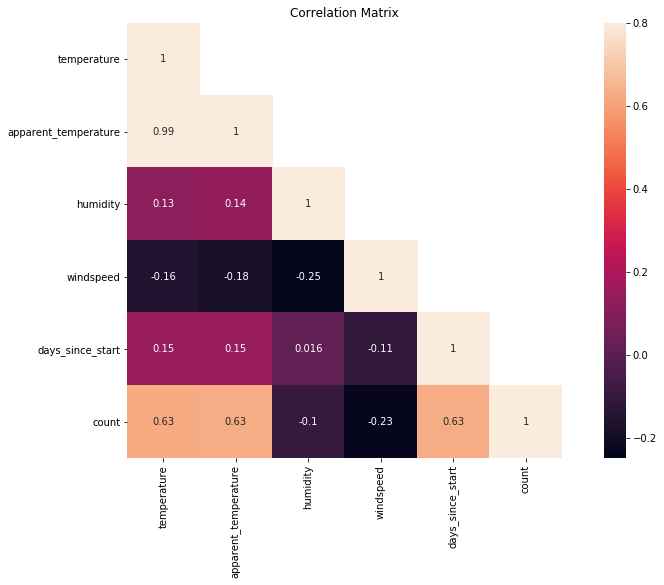

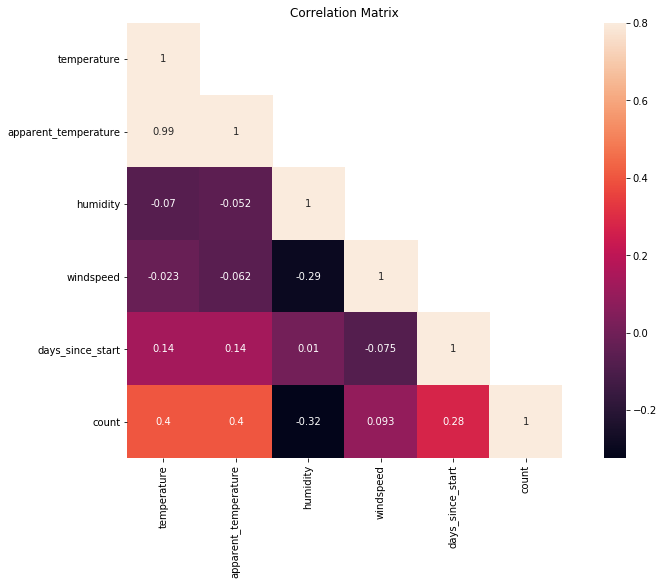

In [30]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Plot correlation matrix
    correlationMatrix=data_set.variants[variant_market].data_frame[[col_temperature, col_apparent_temperature, 
                                                                    col_humidity, col_windspeed, col_days_since_start, 
                                                                    col_count]].corr()
    mask=np.array(correlationMatrix)
    mask[np.tril_indices_from(mask)]=False
    
    fig,ax=plt.subplots(figsize=(15,8))
    sns.heatmap(correlationMatrix,mask=mask,vmax=0.8,square=True,annot=True,ax=ax)
    ax.set_title('Correlation Matrix')
    plt.show()

### 4.3.2 Variant <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fb5e0;">history</span>

In [31]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Days / hours to look backwards
    historical_period = 1
    
    # Copy columns into hist columns and shift them by X
    data_set.variants[variant_history].data_frame[col_weather_situation_hist] = data_set.variants[variant_history].data_frame[col_weather_situation].shift(historical_period)
    data_set.variants[variant_history].data_frame[col_temperature_hist] = data_set.variants[variant_history].data_frame[col_temperature].shift(historical_period)
    data_set.variants[variant_history].data_frame[col_apparent_temperature_hist] = data_set.variants[variant_history].data_frame[col_apparent_temperature].shift(historical_period)
    data_set.variants[variant_history].data_frame[col_humidity_hist] = data_set.variants[variant_history].data_frame[col_humidity].shift(historical_period)
    data_set.variants[variant_history].data_frame[col_windspeed_hist] = data_set.variants[variant_history].data_frame[col_windspeed].shift(historical_period)
    
    # Remove row historical_period
    data_set.variants[variant_history].data_frame = data_set.variants[variant_history].data_frame.iloc[historical_period:]
    
    # One-hot encode columns 
    data_set.variants[variant_history].data_frame = pd.concat([data_set.variants[variant_history].data_frame, pd.get_dummies(data_set.variants[variant_history]
                                                                              .data_frame[col_weather_situation_hist], prefix=col_weather_situation_hist)],axis=1)
    # Drop one-hot encoded columns
    data_set.variants[variant_history].data_frame.drop([col_weather_situation_hist], axis=1, inplace=True)

In [32]:
data_sets[data_set_day].variants[variant_history].data_frame.head()

,instant,datetime,season,year,month,holiday,weekday,workingday,weather_situation,temperature,...,weather_situation_1,weather_situation_2,weather_situation_3,temperature_hist,apparent_temperature_hist,humidity_hist,windspeed_hist,weather_situation_hist_1,weather_situation_hist_2,weather_situation_hist_3
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,1,0,0.344167,0.363625,0.805833,0.160446,0,1,0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,1,0,0,0.363478,0.353739,0.696087,0.248539,0,1,0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,1,0,0,0.196364,0.189405,0.437273,0.248309,1,0,0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,1,0,0,0.200000,0.212122,0.590435,0.160296,1,0,0
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,...,1,0,0,0.226957,0.229270,0.436957,0.186900,1,0,0


### 4.3.3 Variant <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #ff8080;">reduced</span>

In [33]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_season + "_")), axis=1, inplace=True)
    data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex="^" + col_apparent_temperature + "$")), axis=1, inplace=True)
    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_weekday + "_")), axis=1, inplace=True)
    # data_set.variants[variant_reduced].data_frame.drop(list(data_set.variants[variant_reduced].data_frame.filter(regex=col_month + "_")), axis=1, inplace=True)

In [34]:
data_sets[data_set_day].variants[variant_reduced].data_frame.head()

,instant,datetime,season,year,month,holiday,weekday,workingday,weather_situation,temperature,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_0,workingday_1,weather_situation_1,weather_situation_2,weather_situation_3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,...,0,0,0,0,1,1,0,0,1,0
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,...,0,0,0,0,0,1,0,0,1,0
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,...,0,0,0,0,0,0,1,1,0,0
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,...,1,0,0,0,0,0,1,1,0,0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,...,0,1,0,0,0,0,1,1,0,0


## 4.4 Normalize data

Nothing to be done here since features are already normalized.

## 4.5 Drop columns

* The following columns need to be dropped
  * Indices
    * _instant_ since it does not contain any information besides the order
  * Columns which cannot be used directly
    * _datetime_ which is formatted ```yyyy-mm-dd```
  * Columns which are one-hot encoded
  * Columns which contain raw values
  * Unused target columns

In [35]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():
    
    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Drop index and unusable columns
        variant.data_frame.drop([col_instant, col_datetime], axis=1, inplace=True)
        # Drop one-hot encoded columns
        variant.data_frame.drop(data_set.columns_categorical, axis=1, inplace=True)
        # Drop raw-value columns
        variant.data_frame.drop(columns_raw_values, axis=1, inplace=True)
        # Drop unused target columns    
        variant.data_frame.drop([col_casual, col_registered], axis=1, inplace=True)

# 5 Split data into _training_ and _test_

In [36]:
class DataSplit:
    """Contains results of a train/test data split"""
    def __init__(self, _x_train, _x_test, _y_train, _y_test):
        self.x_train = _x_train
        self.x_test = _x_test
        self.y_train = _y_train
        self.y_test = _y_test

In [37]:
# Number of splits
n_splits = 10

# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():
        
        # Define columns
        data_bike_x = variant.data_frame.drop([col_count], axis=1)
        data_bike_y = variant.data_frame[[col_count]]
        
        # Random state to generate reproducible results 
        random_state = 0
        
        # Initialize KFold
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        
        fold_index = 0
        variant.folds = {}
        
        for train_index, test_index in kf.split(data_bike_x):
        
            x_train, x_test = data_bike_x.iloc[train_index], data_bike_x.iloc[test_index]
            y_train, y_test = data_bike_y.iloc[train_index], data_bike_y.iloc[test_index]
            
            # Add splitted data 
            variant.folds[fold_index] = DataSplit(x_train, x_test, y_train, y_test)  
            
            # Show splitted data
            # print("data set " + data_set_name + " / variant " + variant_name + " / " + str(x_train.shape) + ", " + str(x_test.shape) + ", " + str(y_train.shape) + ", " + str(y_test.shape))

            fold_index += 1
            

# 6 Initialize model

In [38]:
# Number of estimators for ensemble learning
n_estimators = 200

# Random state to generate reproducible results 
random_state = 0

In [39]:
# Models
model_linear_regression = "Linear Regression"
model_decision_tree_regressor_200 = "Decision Tree Regressor (200)"
model_gradient_boosting_regressor = "Gradient Boosting Regressor"
model_random_forest_regressor_200 = "Random Forest Regressor (200)"
model_random_forest_regressor_hp_optimized = "Random Forest Regressor (hp-optimized)"
model_lasso_1_0 = "Lasso (1.0)"
model_elastic_net_1_0 = "Elastic Net (1.0)"
model_ridge_1_0 =  "Ridge (1.0)"

# Put models into dictionary
models = {
    model_linear_regression: LinearRegression(),
    model_decision_tree_regressor_200: DecisionTreeRegressor(min_samples_split=10, max_leaf_nodes=200, random_state=random_state),
    model_gradient_boosting_regressor: GradientBoostingRegressor(random_state=random_state),
    model_random_forest_regressor_200: RandomForestRegressor(n_estimators=n_estimators, random_state=random_state),
    model_lasso_1_0: Lasso(alpha=1.0, random_state=random_state),
    model_elastic_net_1_0: ElasticNet(alpha=1.0, random_state=random_state),
    model_ridge_1_0: Ridge(alpha=1.0, random_state=random_state),
}

In [40]:
# Iterate over data sets
for data_set_name, data_set in data_sets.items():

    # Iterate over variants
    for variant_name, variant in data_set.variants.items():

        # Iterate over models
        for model_name, model in models.items():

            # Attach model to variant
            variant.models[model_name] = model

# 7 Train and evaluate model

## 7.1 Preview performance

* Do preliminary investigation to get a first impression on how different models perform
* Using only data set ```day``` and variant ```original``` 

In [41]:
def train_and_evaluate_data_set_preview(_data_set_name, _data_set):
    """Trains and evaluates a given data set"""

    _variant_name = variant_original
    _variant = _data_set.variants[variant_original]

    variant_index = 1
    y_pos = np.arange(len(models.keys()))
    handles = []
    
    plt.figure(figsize=(10,2.5))

    print(_variant_name)
    
    model_index = 0
    metric_r2_score_list = []

    # Iterate over models in variant
    for _model_name, _model in variant.models.items():

        _start = time.time()

        # Initialize metric
        metric_r2_score = 0

        # Iterate over folds in variant
        for _fold_name, _fold in variant.folds.items():
            
            # Fit model and create prediction
            _model.fit(_fold.x_train, _fold.y_train)

            # Make prediction
            predicted_values = _model.predict(_fold.x_test)
            expected_values = _fold.y_test

            # Calculate scores
            metric_r2_score += r2_score(expected_values, predicted_values)

        fold_count = len(variant.folds.items())

        # Divide scores by number of folds
        metric_r2_score /= fold_count

        _end = time.time()
        print("  (" + str(round(_end-_start, 2)) + "s)\t" + _model_name + " > " + str(round(metric_r2_score, 2)))
        
        metric_r2_score_list.insert(model_index, metric_r2_score)
        model_index += 1
        
    variant_count = 1
    
    handle = plt.barh(y_pos, metric_r2_score_list, 0.8 / variant_count, align='center', alpha=0.5, color="grey", label=_variant_name)
    handles.insert(variant_index, handle)
    
    plt.xlabel('R2 Score')
    plt.yticks(y_pos, models.keys())
    plt.title('Model performance')
    plt.legend(handles=handles)
    plt.show()

original
  (0.56s)	Linear Regression > 0.68
  (1.58s)	Decision Tree Regressor (200) > 0.83
  (20.2s)	Gradient Boosting Regressor > 0.79
  (379.61s)	Random Forest Regressor (200) > 0.93
  (0.75s)	Lasso (1.0) > 0.66
  (0.51s)	Elastic Net (1.0) > 0.19
  (0.32s)	Ridge (1.0) > 0.68


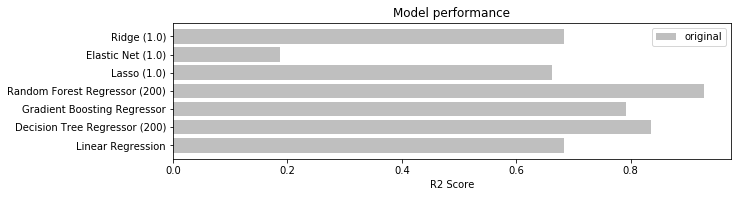

Wall time: 6min 43s


In [42]:
# Train and evaluate data set 'day'
%time train_and_evaluate_data_set_preview(data_set_day, data_sets[data_set_day])

## 7.2 Hyper-parameter optimization

* Do hype-parameter optimization for the model that performed best in preliminary investigation

In [43]:
# Utility function to report best scores
def report(_results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(_results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  _results['mean_test_score'][candidate],
                  _results['std_test_score'][candidate]))
            print("Parameters: {0}".format(_results['params'][candidate]))
            print("")

In [44]:
# Random state to generate reproducible results 
random_state = 0

def optimize_parameter_for_random_forest(data_frame, estimator, iterations):

    # Parameter distribution
    param_distribution = {
        "n_estimators": [n_estimators],
        "criterion": ["mse"], 
        "min_samples_split": sp_randint(2, 20),
        "min_samples_leaf": sp_randint(2, 20),
        "max_depth": sp_randint(3, 10)
    }
    
    # Define columns
    data_bike_x = data_frame.drop([col_count], axis=1)
    data_bike_y = data_frame[[col_count]]
    
    # Initialize random search
    random_search = RandomizedSearchCV(estimator=estimator, 
                                       param_distributions=param_distribution,
                                       n_iter=iterations, cv=5, iid=False, random_state=random_state)
    
    # Fit random search model
    start = time.time()
    random_search.fit(data_bike_x, data_bike_y)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
          " parameter settings." % ((time.time() - start), iterations))
    
    # Extract results
    results = random_search.cv_results_
    
    # Show results
    report(results)
    
    # Determine best parameters
    best_index = np.nonzero(results['rank_test_score'] == 1)[0][0]
    best_parameters = results["params"][best_index]
    
    # Store best parameters
    hp_optimized_max_depth = best_parameters['max_depth']
    hp_optimized_min_samples_leaf = best_parameters['min_samples_leaf']
    hp_optimized_min_samples_split = best_parameters['min_samples_split']
    
    return RandomForestRegressor(
            max_depth=hp_optimized_max_depth, 
            min_samples_leaf=hp_optimized_min_samples_leaf, 
            min_samples_split=hp_optimized_min_samples_split, 
            n_estimators=n_estimators,
            random_state=random_state)

In [45]:
def optimize_parameter_for_data_frame(_data_set_name, _data_set, iterations):

    d = _data_set.variants[variant_original].data_frame
    m = models[model_random_forest_regressor_200]

    # Optimize model
    hp_optimized_model_name = model_random_forest_regressor_hp_optimized + " for " + _data_set_name
    hp_optimized_model = optimize_parameter_for_random_forest(d, m, iterations)
    
    # Add optimized model to general list of models
    models[hp_optimized_model_name] = hp_optimized_model
    
    # Iterate over variants
    for _variant_name, _variant in _data_set.variants.items():

        # Add optimized model to specific list of models
        _variant.models[model_random_forest_regressor_hp_optimized] = hp_optimized_model

In [46]:
# Train and evaluate data set 'day'
%time optimize_parameter_for_data_frame(data_set_day, data_sets[data_set_day], 500)

RandomizedSearchCV took 1449.79 seconds for 500 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.247 (std: 0.215)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.247 (std: 0.215)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.244 (std: 0.214)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.244 (std: 0.214)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 200}

Wall time: 24min 9s


In [47]:
# Train and evaluate data set 'day'
%time optimize_parameter_for_data_frame(data_set_hour, data_sets[data_set_hour], 10)

RandomizedSearchCV took 485.52 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.537 (std: 0.084)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 9, 'min_samples_split': 16, 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.500 (std: 0.091)
Parameters: {'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 17, 'min_samples_split': 17, 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.404 (std: 0.102)
Parameters: {'criterion': 'mse', 'max_depth': 7, 'min_samples_leaf': 17, 'min_samples_split': 2, 'n_estimators': 200}

Wall time: 8min 5s


## 7.3 Train all data sets, variants and models

In [48]:
def train_and_evaluate_data_set(data_set_name, data_set):
    """Trains and evaluates a given data set"""

    variant_index = 0
    y_pos = np.arange(len(data_set.variants[variant_original].models.keys()))
    handles = []

    plt.figure(figsize=(10,10))

    # Iterate over variants
    for _variant_name, _variant in data_set.variants.items():

        print(_variant_name)

        model_index = 0
        metric_r2_score_list = []

        # Iterate over models in variant
        for _model_name, _model in _variant.models.items():

            _start = time.time()

            # Initialize metric
            metric_r2_score = 0

            # Iterate over folds in variant
            for _fold_name, _fold in _variant.folds.items():
                
                # Fit model and create prediction
                _model.fit(_fold.x_train, _fold.y_train)

                # Make prediction
                predicted_values = _model.predict(_fold.x_test)
                expected_values = _fold.y_test

                # Calculate scores
                metric_r2_score += r2_score(expected_values, predicted_values)

            fold_count = len(_variant.folds.items())

            # Divide scores by number of folds
            metric_r2_score /= fold_count

            _end = time.time()
            print("  (" + str(round(_end-_start, 2)) + "s)\t" + _model_name + " > " + str(round(metric_r2_score, 2)))
            
            metric_r2_score_list.insert(model_index, metric_r2_score)
            model_index += 1

        print("")

        variant_count = len(data_set.variants)
    
        handle = plt.barh(y_pos + (0.8 * variant_index / variant_count), 
                          metric_r2_score_list, 
                          0.8 / variant_count, 
                          align='center', 
                          alpha=0.5, 
                          color=_variant.color, 
                          label=_variant_name)
        handles.insert(variant_index, handle)
        variant_index += 1

    plt.xlabel('R2 Score')
    plt.yticks(y_pos, models.keys())
    plt.title('Model performance')
    plt.legend(handles=handles)
    plt.show()
    

### 7.3.1 Data Set _day_

original
  (0.09s)	Linear Regression > 0.83
  (0.14s)	Decision Tree Regressor (200) > 0.81
  (1.6s)	Gradient Boosting Regressor > 0.89
  (14.05s)	Random Forest Regressor (200) > 0.88
  (0.16s)	Lasso (1.0) > 0.83
  (0.07s)	Elastic Net (1.0) > 0.53
  (0.05s)	Ridge (1.0) > 0.83
  (7.43s)	Random Forest Regressor (hp-optimized) > 0.85

market
  (0.08s)	Linear Regression > 0.83
  (0.15s)	Decision Tree Regressor (200) > 0.8
  (1.73s)	Gradient Boosting Regressor > 0.9
  (14.68s)	Random Forest Regressor (200) > 0.88
  (0.14s)	Lasso (1.0) > 0.83
  (0.07s)	Elastic Net (1.0) > 0.55
  (0.06s)	Ridge (1.0) > 0.83
  (7.81s)	Random Forest Regressor (hp-optimized) > 0.85

history
  (0.07s)	Linear Regression > 0.83
  (0.16s)	Decision Tree Regressor (200) > 0.76
  (1.96s)	Gradient Boosting Regressor > 0.89
  (18.57s)	Random Forest Regressor (200) > 0.87
  (0.14s)	Lasso (1.0) > 0.84
  (0.08s)	Elastic Net (1.0) > 0.55
  (0.06s)	Ridge (1.0) > 0.84
  (9.83s)	Random Forest Regressor (hp-optimized) > 0.84

redu

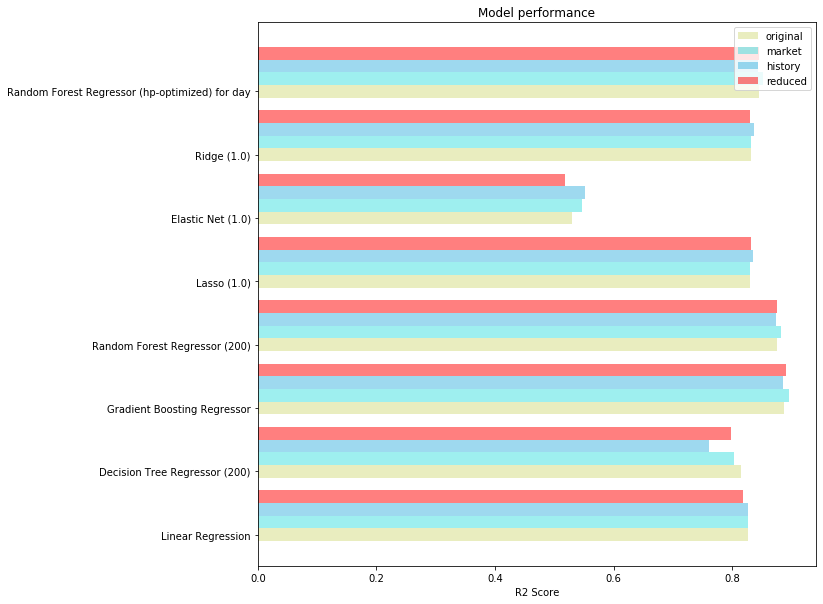

Wall time: 1min 41s


In [49]:
# Train and evaluate data set 'day'
%time train_and_evaluate_data_set(data_set_day, data_sets[data_set_day])

### 7.3.2 Data Set _hour_

original
  (0.57s)	Linear Regression > 0.68
  (2.35s)	Decision Tree Regressor (200) > 0.82
  (35.85s)	Gradient Boosting Regressor > 0.79
  (467.39s)	Random Forest Regressor (200) > 0.93
  (0.82s)	Lasso (1.0) > 0.66
  (0.48s)	Elastic Net (1.0) > 0.19
  (0.32s)	Ridge (1.0) > 0.68
  (172.82s)	Random Forest Regressor (hp-optimized) > 0.73

market
  (0.55s)	Linear Regression > 0.68
  (2.57s)	Decision Tree Regressor (200) > 0.83
  (36.69s)	Gradient Boosting Regressor > 0.79
  (514.51s)	Random Forest Regressor (200) > 0.93
  (0.9s)	Lasso (1.0) > 0.66
  (0.57s)	Elastic Net (1.0) > 0.2
  (0.34s)	Ridge (1.0) > 0.68
  (192.43s)	Random Forest Regressor (hp-optimized) > 0.74

history
  (0.63s)	Linear Regression > 0.69
  (2.87s)	Decision Tree Regressor (200) > 0.82
  (42.04s)	Gradient Boosting Regressor > 0.79
  (617.76s)	Random Forest Regressor (200) > 0.93
  (0.88s)	Lasso (1.0) > 0.67
  (0.59s)	Elastic Net (1.0) > 0.22
  (0.39s)	Ridge (1.0) > 0.69
  (229.39s)	Random Forest Regressor (hp-optimized)

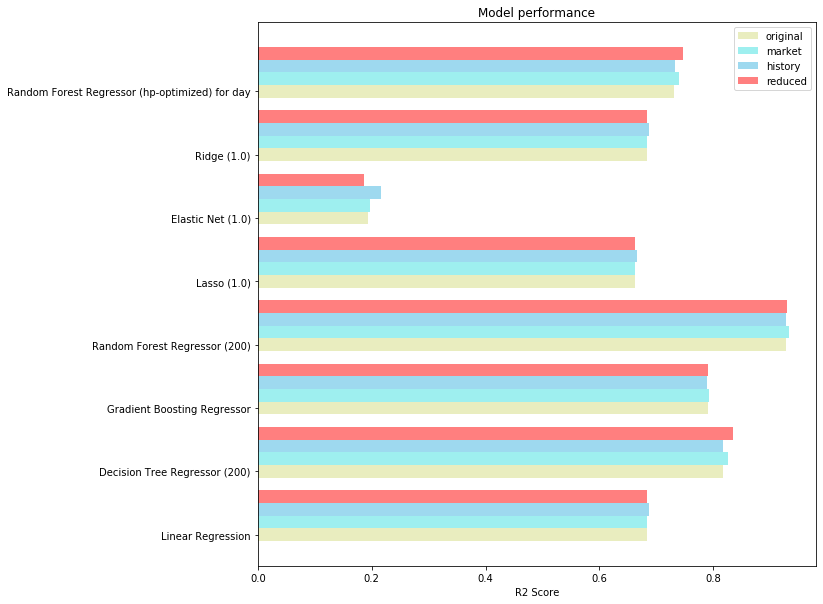

Wall time: 49min 5s


In [50]:
# Train and evaluate data set 'hour'
%time train_and_evaluate_data_set(data_set_hour, data_sets[data_set_hour])

# 8 Conclusion

## 8.1 Hypothesis A <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fe0e0;">time in the market</span>

In ```day``` data set using synthetic feature _days since start_ did not improve the performance when using
* Linear Regression
* Decision Tree Regressor (200)
* Lasso (1.0)
* Elastic Net (1.0)
* Ridge (1.0)

... and slightly improves the performance when using
* Random Forest Regressor (200)
* Gradient Boosting Regressor

## 8.2 Hypothesis B <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #3fb5e0;">historic weather data</span>

In ```day``` data set using historic data slightly increased performance when using

* Lasso (1.0)
* Elastic Net (1.0)
* Ridge (1.0)

... did not affect the performance when using
* Linear Regression
* Gradient Boosting Regressor 
* Random Forest Regressor (200)
* Decision Tree Regressor (200)

## 8.3 Hypothesis C <span style="font-style:italic; font-weight: 700; padding: 1px 5px; border-radius: 2px; font-family: monospace; background-color: #ff8080;">dimensionality reduction</span>

In ```day``` data set manually reducing the dimensionality by removing _apparent temperature_ slightly decreases the 
performance when using

* Linear Regression (200)
* Decision Tree Regressor (200)
* Elastic Net (1.0)

... did not affect the performance
* Random Forest Regressor
* Lasso (1.0)
* Rigde (1.0)
* GradientBoostingRegressor

There is no model which increased its performance compared to the original data.

# Tools and platforms

## Dev environment

<img style="float: left; height: 40px" src="../img/anaconda.jpg">
<img style="float: left; height: 40px" src="../img/pycharm.jpg">
<img style="float: left; height: 40px" src="../img/git.png">
<div style="display: block; clear: both;"> </div>

* [PyCharm Professional Edition for Anaconda](https://www.jetbrains.com/pycharm/promo/anaconda/)
  * Debugging and insights
  * Code completion
  * Git integration
* [Git](https://git-scm.com/)
  * Versioning
  
```QUESTION``` How can Jupyter notebooks be versioned without output and execution count?
  
## Hosting

<img style="float: left; height: 40px" src="../img/github.png">
<img style="float: left; height: 40px" src="../img/colab.png">
<img style="float: left; height: 40px" src="../img/binder.png">
<div style="display: block; clear: both;"> </div>

* [Github](https://github.com)
  * Code hosting
* [binder](https://mybinder.org/) and [Colab](https://colab.research.google.com)
  * Loading from Github
  * Notebook execution
  * Compute power
  
# Follow-up questions

```QUESTION``` How is machine learning done in a professional context?
 
* Are Jupyter notebooks primarily used for proof of concepts and demos?
* How and where are models usually trained?

```QUESTION``` How are trained models used by customers / integrated into existing applications?

* How are models persisted, delivered and updated?
* Can we discuss the usage of pickle during the lecture?